In [ ]:
#3) Ingesta desde API pública (Binance) → guardado a CSV

In [1]:

# Dependencias y carpetas
import os, time, requests
import pandas as pd
from pathlib import Path

DATA_RAW = Path("data/raw")
DATA_RAW.mkdir(parents=True, exist_ok=True)

# Funciones API Binance

BIN = "https://api.binance.com/api/v3/klines"

def _to_ms(dt_str: str) -> int:
    return int(pd.Timestamp(dt_str, tz="UTC").timestamp() * 1000)

def get_klines(symbol="BTCUSDT", interval="1d", start="2017-01-01", end=None, limit=1000, sleep=0.25):
    
    if end is None:
        end = pd.Timestamp.utcnow().strftime("%Y-%m-%d")
    start_ms, end_ms = _to_ms(start), _to_ms(end)
    out, cur = [], start_ms
    while True:
        params = {"symbol": symbol, "interval": interval, "limit": limit, "startTime": cur, "endTime": end_ms}
        r = requests.get(BIN, params=params, timeout=30)
        if r.status_code in (418, 429):  # rate limit
            time.sleep(2); continue
        r.raise_for_status()
        chunk = r.json()
        if not chunk:
            break
        out.extend(chunk)
        last_open = chunk[-1][0]
        cur = last_open + 1
        if cur >= end_ms: break
        time.sleep(sleep)
    cols = ["open_time","open","high","low","close","volume","close_time","qav","trades","tb_base","tb_quote","ignore"]
    df = pd.DataFrame(out, columns=cols)
    df[["open","high","low","close","volume"]] = df[["open","high","low","close","volume"]].astype(float)
    df["timestamp"] = pd.to_datetime(df["open_time"], unit="ms", utc=True)
    return df[["timestamp","open","high","low","close","volume"]]


# Descarga y persistencia

RUN_API = True  

if RUN_API:
    
    btc = get_klines("BTCUSDT", "1d", start="2017-01-01")
    eth = get_klines("ETHUSDT", "1d", start="2017-01-01")

    btc.to_csv(DATA_RAW/"binance_BTCUSDT_1d.csv", index=False)
    eth.to_csv(DATA_RAW/"binance_ETHUSDT_1d.csv", index=False)
    print("Guardado en:", (DATA_RAW/"binance_BTCUSDT_1d.csv").resolve())
    print("Guardado en:", (DATA_RAW/"binance_ETHUSDT_1d.csv").resolve())

Guardado en: /home/romina/Escritorio/FInalProjectBTCvsRTH/data/raw/binance_BTCUSDT_1d.csv
Guardado en: /home/romina/Escritorio/FInalProjectBTCvsRTH/data/raw/binance_ETHUSDT_1d.csv


In [ ]:
#4)Carga desde CSV (trabajo offline)

In [2]:
import pandas as pd
from pathlib import Path

DATA_RAW = Path("data/raw")

btc = pd.read_csv(DATA_RAW/"binance_BTCUSDT_1d.csv", parse_dates=["timestamp"])
eth = pd.read_csv(DATA_RAW/"binance_ETHUSDT_1d.csv", parse_dates=["timestamp"])

#Normalizamos nombres y preparamos campos básicos
btc = btc.rename(columns={"close":"price"}); btc["symbol"]="BTC"
eth = eth.rename(columns={"close":"price"}); eth["symbol"]="ETH"

#Alineación por fechas comunes (para comparabilidad)
start = max(btc["timestamp"].min(), eth["timestamp"].min())
end   = min(btc["timestamp"].max(), eth["timestamp"].max())
btc = btc[(btc["timestamp"]>=start) & (btc["timestamp"]<=end)].reset_index(drop=True)
eth = eth[(eth["timestamp"]>=start) & (eth["timestamp"]<=end)].reset_index(drop=True)

common_days = sorted(set(btc["timestamp"]).intersection(set(eth["timestamp"])))
btc = btc[btc["timestamp"].isin(common_days)].reset_index(drop=True)
eth = eth[eth["timestamp"].isin(common_days)].reset_index(drop=True)

#Retornos diarios
btc["ret_d"] = btc["price"].pct_change()
eth["ret_d"] = eth["price"].pct_change()



In [ ]:
#5) Resumen de metadata (inicio de EDA)

#Un pantallazo rápido de tamaño, tipos y nulos para documentar el dataset.

In [3]:
import numpy as np

def meta(df, name):
    return pd.DataFrame({
        "rows":[len(df)],
        "cols":[df.shape[1]],
        "fecha_min":[df["timestamp"].min()],
        "fecha_max":[df["timestamp"].max()],
        "nulos_price":[df["price"].isna().sum()],
        "nulos_ret_d":[df["ret_d"].isna().sum()]
    }, index=[name])

meta_df = pd.concat([meta(btc,"BTC"), meta(eth,"ETH")])
display(meta_df)

print("\nTipos BTC:\n", btc.dtypes)
print("\nTipos ETH:\n", eth.dtypes)


,rows,cols,fecha_min,fecha_max,nulos_price,nulos_ret_d
BTC,3010,8,2017-08-17 00:00:00+00:00,2025-11-12 00:00:00+00:00,0,1
ETH,3010,8,2017-08-17 00:00:00+00:00,2025-11-12 00:00:00+00:00,0,1



Tipos BTC:
 timestamp    datetime64[ns, UTC]
open                     float64
high                     float64
low                      float64
price                    float64
volume                   float64
symbol                    object
ret_d                    float64
dtype: object

Tipos ETH:
 timestamp    datetime64[ns, UTC]
open                     float64
high                     float64
low                      float64
price                    float64
volume                   float64
symbol                    object
ret_d                    float64
dtype: object


In [4]:
#6)Feature engineering: vol, drawdown, momentum, panele
import numpy as np
import pandas as pd

def _add_features(d: pd.DataFrame) -> pd.DataFrame:
    d = d.copy()
    d["ret_d"]   = d["price"].pct_change()
    d["abs_ret"] = d["ret_d"].abs()
    #volatilidad anualizada rolling
    d["vol_30"] = d["ret_d"].rolling(30, min_periods=15).std() * np.sqrt(365)
    d["vol_90"] = d["ret_d"].rolling(90, min_periods=45).std() * np.sqrt(365)
    #drawdown
    peak = d["price"].cummax()
    d["dd"] = d["price"]/peak - 1.0
    #momentum
    d["mom_30"] = d["price"]/d["price"].shift(30) - 1
    d["mom_90"] = d["price"]/d["price"].shift(90) - 1
    #índice base=100 para gráfico de precio
    base = d["price"].iloc[0]
    d["idx100"] = 100*d["price"]/base
    return d

btc = _add_features(btc)
eth = _add_features(eth)

#Paneles para gráficos y correlaciones
pv_price = pd.DataFrame({
    "timestamp": btc["timestamp"].values,
    "BTC": btc["price"].values,
    "ETH": eth["price"].values
}).set_index("timestamp")

pv_ret = pd.DataFrame({
    "timestamp": btc["timestamp"].values,
    "BTC": btc["ret_d"].values,
    "ETH": eth["ret_d"].values
}).set_index("timestamp").dropna()

#Fortaleza relativa ETH/BTC
pv_price["ETH_BTC"] = pv_price["ETH"]/pv_price["BTC"]

#Spearman  correlación de retornos
rho_s = pv_ret.corr(method="spearman").loc["BTC","ETH"] if len(pv_ret)>5 else np.nan
rho_s


0.7798422163882284

In [5]:
#Guardado de figuras
from pathlib import Path
import matplotlib.pyplot as plt

FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(fig, name, dpi=180):
    out = FIG_DIR / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight", facecolor="white", transparent=False)
    print(f"✅ guardada: {out.resolve()}")


In [ ]:
#8) Visualizaciones y análisis

In [6]:
import matplotlib.pyplot as plt


✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/01_precio_normalizado.png


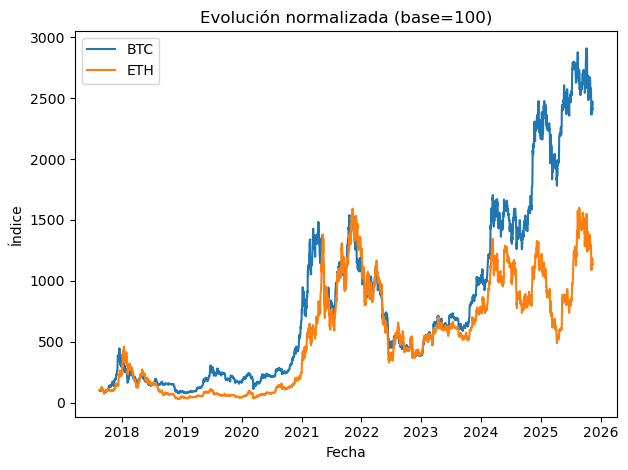

In [7]:
#1)Precio normalizado (base=100)
fig, ax = plt.subplots()
ax.plot(btc["timestamp"], btc["idx100"], label="BTC")
ax.plot(eth["timestamp"], eth["idx100"], label="ETH")
ax.set_title("Evolución normalizada (base=100)")
ax.set_xlabel("Fecha"); ax.set_ylabel("Índice"); ax.legend(); fig.tight_layout()
savefig(fig, "01_precio_normalizado.png")
plt.show()

✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/02_volatilidad_90d.png


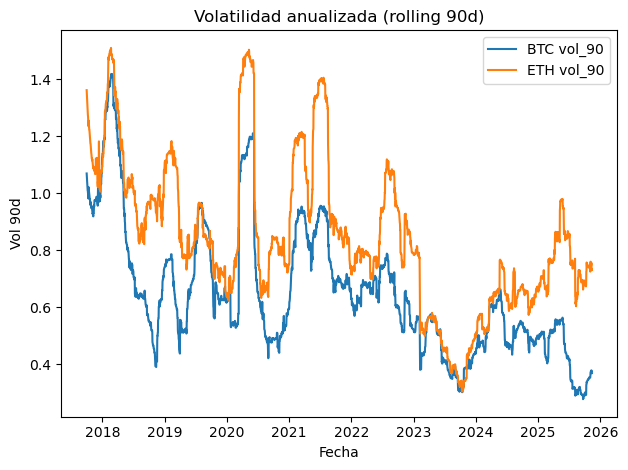

In [8]:
#2)Volatilidad anualizada (rolling 90d)
fig, ax = plt.subplots()
ax.plot(btc["timestamp"], btc["vol_90"], label="BTC vol_90")
ax.plot(eth["timestamp"], eth["vol_90"], label="ETH vol_90")
ax.set_title("Volatilidad anualizada (rolling 90d)")
ax.set_xlabel("Fecha"); ax.set_ylabel("Vol 90d"); ax.legend(); fig.tight_layout()
savefig(fig, "02_volatilidad_90d.png")
plt.show()

✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/03_drawdowns.png


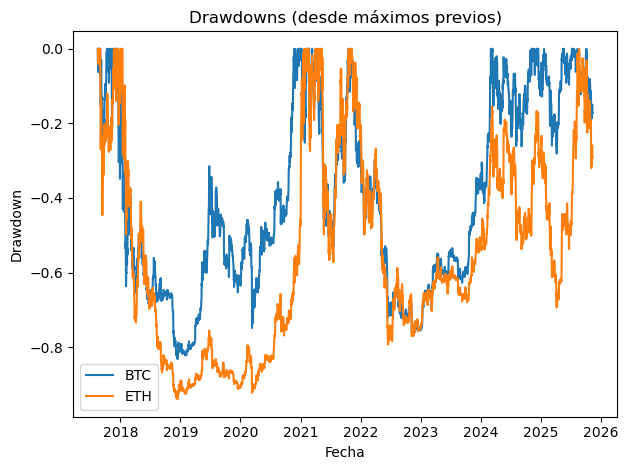

In [9]:
#3)Drawdowns
fig, ax = plt.subplots()
ax.plot(btc["timestamp"], btc["dd"], label="BTC")
ax.plot(eth["timestamp"], eth["dd"], label="ETH")
ax.set_title("Drawdowns (desde máximos previos)")
ax.set_xlabel("Fecha"); ax.set_ylabel("Drawdown"); ax.legend(); fig.tight_layout()
savefig(fig, "03_drawdowns.png")
plt.show()

✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/04_correlacion_spearman.png


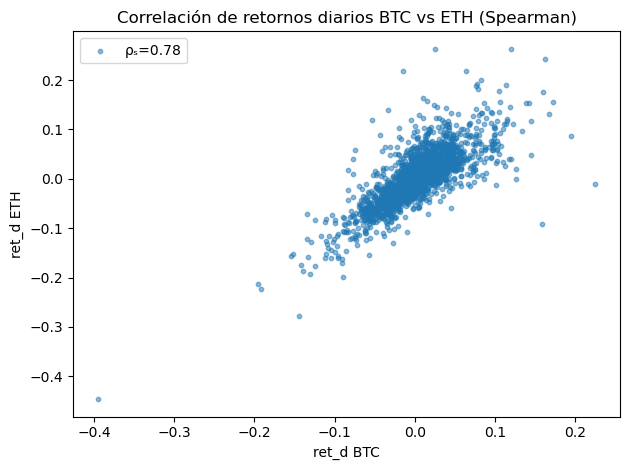

In [10]:
#4)Correlación de retornos (Sperman)
fig, ax = plt.subplots()
ax.scatter(pv_ret["BTC"], pv_ret["ETH"], s=10, alpha=0.5, label=f"ρₛ={rho_s:.2f}")
ax.set_title("Correlación de retornos diarios BTC vs ETH (Spearman)")
ax.set_xlabel("ret_d BTC"); ax.set_ylabel("ret_d ETH"); ax.legend(); fig.tight_layout()
savefig(fig, "04_correlacion_spearman.png")
plt.show()

✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/05_eth_btc.png


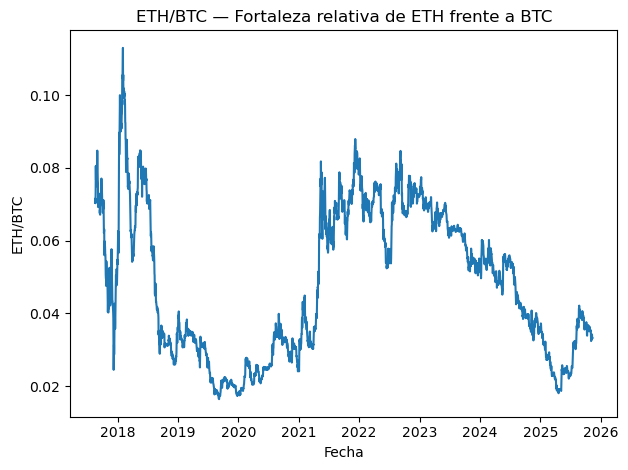

In [11]:
#5)ETH/BTC — Fortaleza relativa
fig, ax = plt.subplots()
ax.plot(pv_price.index, pv_price["ETH_BTC"])
ax.set_title("ETH/BTC — Fortaleza relativa de ETH frente a BTC")
ax.set_xlabel("Fecha"); ax.set_ylabel("ETH/BTC"); fig.tight_layout()
savefig(fig, "05_eth_btc.png")
plt.show()

✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/06_momentum_barras.png


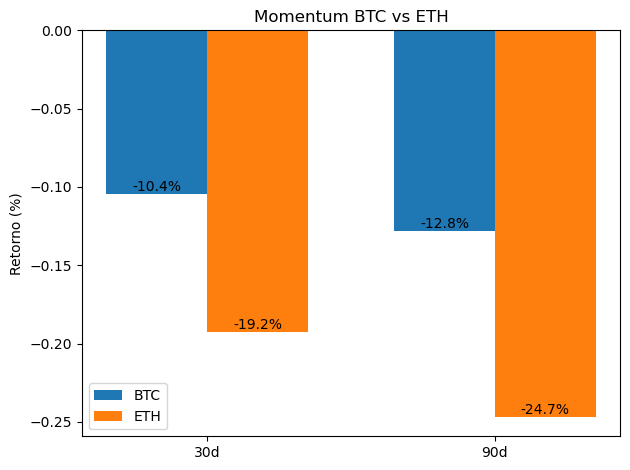

In [12]:
#6)Momentum 30/90 — barras
def _bar_with_labels(ax, labels, v1, v2, title, ylabel):
    import numpy as np
    x = np.arange(len(labels)); w=0.35
    ax.bar(x-w/2, v1, width=w, label="BTC")
    ax.bar(x+w/2, v2, width=w, label="ETH")
    ax.set_xticks(x); ax.set_xticklabels(labels)
    ax.set_title(title); ax.set_ylabel(ylabel); ax.legend()
    for i, val in enumerate(v1):
        ax.text(i-w/2, val, f"{val*100:.1f}%", ha="center", va="bottom")
    for i, val in enumerate(v2):
        ax.text(i+w/2, val, f"{val*100:.1f}%", ha="center", va="bottom")

mom30_btc = btc["mom_30"].iloc[-1]; mom30_eth = eth["mom_30"].iloc[-1]
mom90_btc = btc["mom_90"].iloc[-1]; mom90_eth = eth["mom_90"].iloc[-1]

fig, ax = plt.subplots()
_bar_with_labels(ax, ["30d","90d"], [mom30_btc, mom90_btc], [mom30_eth, mom90_eth],
                 "Momentum BTC vs ETH", "Retorno (%)")
fig.tight_layout()
savefig(fig, "06_momentum_barras.png")
plt.show()

✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/07_spearman_rolling.png


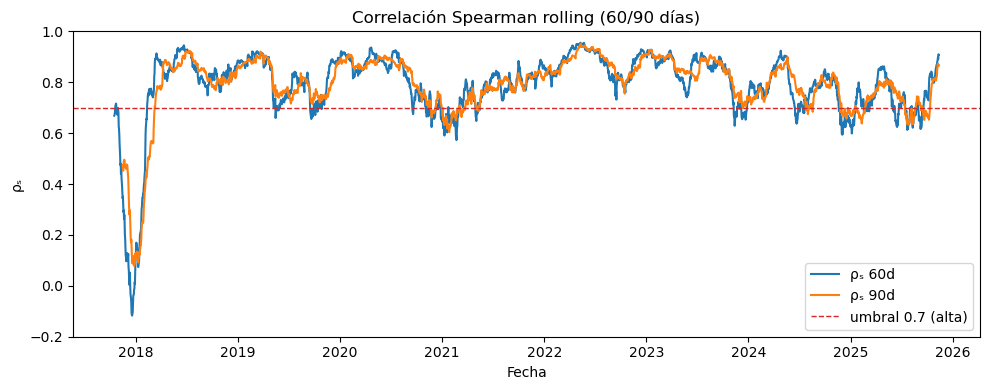

ρₛ total = 0.78 | ρₛ60 último = 0.91 | ρₛ90 último = 0.87
✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/07_diversificacion_curva_vol.png


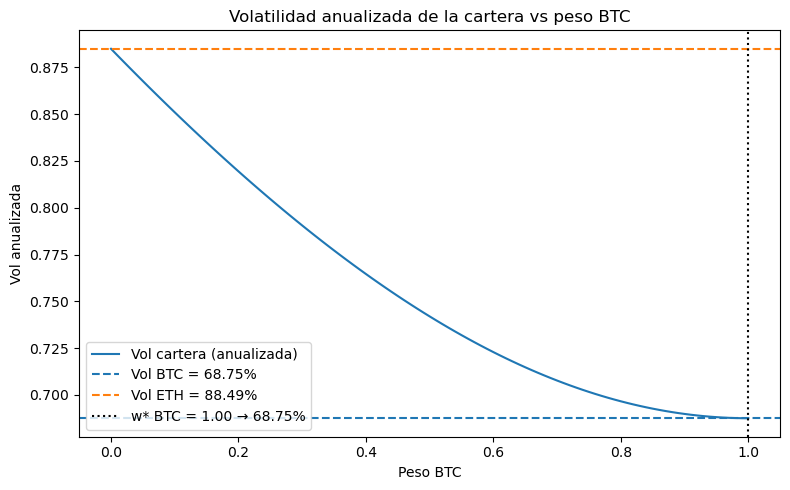

Mín vol cartera = 68.75% con wBTC = 1.00.
Reducción vs activo menos volátil = 0.0% (beneficio de diversificación).


In [13]:
#7) Diversificación BTC–ETH
#Spearman rolling(60/90 días)
def rolling_spearman(series_x: pd.Series, series_y: pd.Series, win: int) -> pd.Series:
    x = series_x.copy(); y = series_y.copy()
    out = np.full(len(x), np.nan)
    for i in range(win-1, len(x)):
        xs = x.iloc[i-win+1:i+1].rank().values
        ys = y.iloc[i-win+1:i+1].rank().values
        out[i] = np.corrcoef(xs, ys)[0, 1]
    return pd.Series(out, index=series_x.index, name=f"rho_s_{win}")

rho60 = rolling_spearman(pv_ret["BTC"], pv_ret["ETH"], 60)
rho90 = rolling_spearman(pv_ret["BTC"], pv_ret["ETH"], 90)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(rho60.index, rho60, label="ρₛ 60d")
ax.plot(rho90.index, rho90, label="ρₛ 90d")
ax.axhline(0.7, color="tab:red", lw=1, ls="--", label="umbral 0.7 (alta)")
ax.set_ylim(-0.2, 1.0)
ax.set_title("Correlación Spearman rolling (60/90 días)")
ax.set_xlabel("Fecha"); ax.set_ylabel("ρₛ"); ax.legend()
fig.tight_layout()
savefig(fig, "07_spearman_rolling.png")
plt.show()

print(f"ρₛ total = {rho_s:.2f} | ρₛ60 último = {rho60.dropna().iloc[-1]:.2f} | ρₛ90 último = {rho90.dropna().iloc[-1]:.2f}")

#2)Cuánto ayuda a diversificar? 
rets = pv_ret.copy()
vol_BTC = rets["BTC"].std() * np.sqrt(365)
vol_ETH = rets["ETH"].std() * np.sqrt(365)

w_grid = np.linspace(0, 1, 101)  # peso BTC
port_vol = []
for w in w_grid:
    rp = w*rets["BTC"] + (1-w)*rets["ETH"]
    port_vol.append(rp.std() * np.sqrt(365))
port_vol = np.array(port_vol)

#Punto de minima volatilidad
i_min = np.argmin(port_vol)
w_star = float(w_grid[i_min])
vol_star = float(port_vol[i_min])

#Beneficio de diversificación: ¿cuánto baja vs el activo menos volátil?
base = min(vol_BTC, vol_ETH)
benefit_pct = (base - vol_star) / base if base > 0 else np.nan

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(w_grid, port_vol, label="Vol cartera (anualizada)")
ax.axhline(vol_BTC, color="tab:blue", ls="--", label=f"Vol BTC = {vol_BTC:.2%}")
ax.axhline(vol_ETH, color="tab:orange", ls="--", label=f"Vol ETH = {vol_ETH:.2%}")
ax.axvline(w_star, color="k", ls=":", label=f"w* BTC = {w_star:.2f} → {vol_star:.2%}")
ax.set_title("Volatilidad anualizada de la cartera vs peso BTC")
ax.set_xlabel("Peso BTC"); ax.set_ylabel("Vol anualizada"); ax.legend()
fig.tight_layout()
savefig(fig, "07_diversificacion_curva_vol.png")
plt.show()

print(f"Mín vol cartera = {vol_star:.2%} con wBTC = {w_star:.2f}.")
print(f"Reducción vs activo menos volátil = {benefit_pct:.1%} (beneficio de diversificación).")

In [ ]:
# 9. Paso 1. Celda 1 - LightGBM con lags y rolling (BTC + ETH combinados)

In [14]:
#Creación de features temporales
#  Creamos lags y rolling para ambas
for df, name in [(btc, "btc"), (eth, "eth")]:
    df[f"{name}_lag_1"] = df["ret_d"].shift(1)
    df[f"{name}_lag_2"] = df["ret_d"].shift(2)
    df[f"{name}_lag_3"] = df["ret_d"].shift(3)
    df[f"{name}_ma_5"] = df["ret_d"].rolling(5).mean()
    df[f"{name}_ma_10"] = df["ret_d"].rolling(10).mean()
    df[f"{name}_vol_5"] = df["ret_d"].rolling(5).std()
    df[f"{name}_vol_10"] = df["ret_d"].rolling(10).std()

#Unimos ambos por fecha (timestamp
data = btc.join(eth, how="inner", lsuffix="_btc", rsuffix="_eth")

#Definimos la variable objetivo
data['target'] = (data['ret_d_btc'] > 0).astype(int)

data.dropna(inplace=True)


In [15]:
print("Columnas BTC:\n", btc.columns)
print("Columnas ETH:\n", eth.columns)

Columnas BTC:
 Index(['timestamp', 'open', 'high', 'low', 'price', 'volume', 'symbol',
       'ret_d', 'abs_ret', 'vol_30', 'vol_90', 'dd', 'mom_30', 'mom_90',
       'idx100', 'btc_lag_1', 'btc_lag_2', 'btc_lag_3', 'btc_ma_5',
       'btc_ma_10', 'btc_vol_5', 'btc_vol_10'],
      dtype='object')
Columnas ETH:
 Index(['timestamp', 'open', 'high', 'low', 'price', 'volume', 'symbol',
       'ret_d', 'abs_ret', 'vol_30', 'vol_90', 'dd', 'mom_30', 'mom_90',
       'idx100', 'eth_lag_1', 'eth_lag_2', 'eth_lag_3', 'eth_ma_5',
       'eth_ma_10', 'eth_vol_5', 'eth_vol_10'],
      dtype='object')


In [16]:
print("Dataset final listo para modelar:\n", data.head())

Dataset final listo para modelar:
                timestamp_btc  open_btc  high_btc  low_btc  price_btc  \
90 2017-11-15 00:00:00+00:00   6575.99   7298.00  6575.99    7240.06   
91 2017-11-16 00:00:00+00:00   7240.14   7940.00  7076.00    7864.50   
92 2017-11-17 00:00:00+00:00   7876.98   7989.00  7451.00    7699.19   
93 2017-11-18 00:00:00+00:00   7680.01   7819.99  7422.00    7761.94   
94 2017-11-19 00:00:00+00:00   7761.94   8123.15  7650.33    8038.00   

     volume_btc symbol_btc  ret_d_btc  abs_ret_btc  vol_30_btc  ...  \
90  1779.605845        BTC   0.101151     0.101151    0.918509  ...   
91  2331.956750        BTC   0.086248     0.086248    0.946617  ...   
92  3982.395925        BTC  -0.021020     0.021020    0.949118  ...   
93  3954.266477        BTC   0.008150     0.008150    0.946775  ...   
94  3867.340444        BTC   0.035566     0.035566    0.936509  ...   

    mom_90_eth  idx100_eth  eth_lag_1  eth_lag_2  eth_lag_3  eth_ma_5  \
90    0.097119  109.711921   0.0

In [17]:
#seleccionamos features relevantes de ambas series

import pandas as pd
import numpy as np

features = [
    'btc_lag_1', 'btc_lag_2', 'btc_lag_3', 'btc_ma_5', 'btc_ma_10', 'btc_vol_5', 'btc_vol_10',
    'eth_lag_1', 'eth_lag_2', 'eth_lag_3', 'eth_ma_5', 'eth_ma_10', 'eth_vol_5', 'eth_vol_10'
]

X = data[features]
y = data['target']

In [18]:
#9. Paso 1. Celda 2 - Entrenamiento con LightGBM

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# División temporal (sin mezcla de fechas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo LightGBM
lgb = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

cv_auc = cross_val_score(lgb, X_train_scaled, y_train, cv=5, scoring="roc_auc").mean()
print(f"AUC promedio en validación cruzada: {cv_auc:.3f}")

lgb.fit(X_train_scaled, y_train)


[LightGBM] [Info] Number of positive: 963, number of negative: 905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1868, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515525 -> initscore=0.062118
[LightGBM] [Info] Start training from score 0.062118
[LightGBM] [Info] Number of positive: 963, number of negative: 906
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515249 -> initscore=0.061014
[LightGBM] [Info] Start training from score 0.061014
[LightGBM] [Info] Number o

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
               num_leaves=64, random_state=42, subsample=0.8)

In [19]:
print(f"AUC promedio en validación cruzada: {cv_auc:.3f}")

AUC promedio en validación cruzada: 0.774


AUC en test: 0.768
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       286
           1       0.71      0.69      0.70       298

    accuracy                           0.70       584
   macro avg       0.70      0.70      0.70       584
weighted avg       0.70      0.70      0.70       584



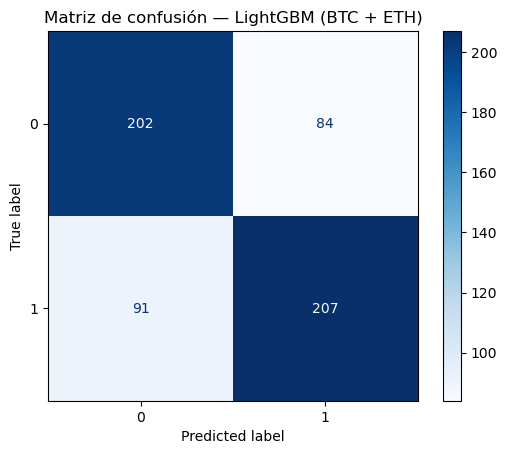

In [20]:
#9. Paso 1. Celda 3 - Evaluación y matriz de confusion 

from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = lgb.predict(X_test_scaled)
y_proba = lgb.predict_proba(X_test_scaled)[:, 1]

print(f"AUC en test: {roc_auc_score(y_test, y_proba):.3f}")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(lgb, X_test_scaled, y_test, cmap="Blues")
plt.title("Matriz de confusión — LightGBM (BTC + ETH)")
plt.savefig("figures/matriz_confusion_lightgbm.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# 9 Paso 2. Celda 1 - Modelo LSTM. Preparacion de secuencias

In [21]:
import tensorflow as tf
print("Versión TensorFlow:", tf.__version__)
print("Dispositivos disponibles:", tf.config.list_physical_devices())


2025-11-11 21:02:13.963282: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 21:02:13.964863: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-11 21:02:14.056991: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-11 21:02:15.047399: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-11 21:02:18.018638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Versión TensorFlow: 2.16.1
Dispositivos disponibles: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
# 9 Paso 2. Celda 2 - Entrenamiento del LSTM

In [22]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler

# Usamos las mismas features que con LightGBM
features = ['btc_lag_1', 'btc_lag_2', 'btc_lag_3', 'btc_ma_5', 'btc_ma_10', 'btc_vol_5', 'btc_vol_10', 'eth_lag_1', 'eth_lag_2', 'eth_lag_3', 'eth_ma_5', 'eth_ma_10', 'eth_vol_5', 'eth_vol_10']
X = data[features].values
y = data["target"].values

# Escalado previo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Generador temporal
time_steps = 10  # ventana de 10 días
generator = TimeseriesGenerator(X_scaled, y, length=time_steps, batch_size=32)

# División temporal (80% train / 20% test)
split = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y[:split], y[split:]

train_gen = TimeseriesGenerator(X_train, y_train, length=time_steps, batch_size=32)
test_gen = TimeseriesGenerator(X_test, y_test, length=time_steps, batch_size=32)



In [23]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, input_shape=(time_steps, len(features)), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])
history = model.fit(train_gen, validation_data=test_gen, epochs=25, verbose=1)


Epoch 1/25


/home/romina/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.5202 - loss: 0.6931 - val_AUC: 0.4864 - val_loss: 0.6982
Epoch 2/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.5291 - loss: 0.6917 - val_AUC: 0.5004 - val_loss: 0.6967
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.5509 - loss: 0.6884 - val_AUC: 0.5061 - val_loss: 0.6951
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.5679 - loss: 0.6854 - val_AUC: 0.5036 - val_loss: 0.6983
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.5744 - loss: 0.6835 - val_AUC: 0.5070 - val_loss: 0.6966
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.5823 - loss: 0.6800 - val_AUC: 0.5098 - val_loss: 0.6957
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6013 - loss: 0.6762 - val_AUC: 0.5128 - val_loss: 0.6954
Epoch 8/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6077 - loss: 0.6732 - val_AUC: 0.5232 - val_loss: 0.6941
Epoch 9/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6074 - loss: 0.6726 - va

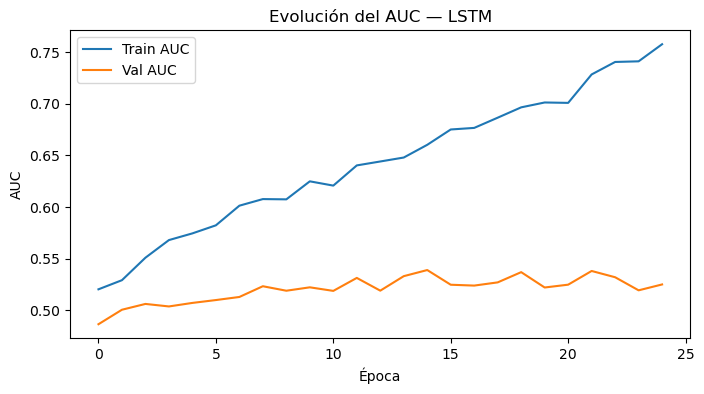

In [24]:
#9 Paso 2. Celda 3 - Evaluación del LSTM
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Val AUC')
plt.title('Evolución del AUC — LSTM')
plt.xlabel('Época')
plt.ylabel('AUC')
plt.legend()
plt.savefig("figures/Evolucion_AUC.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#9 Paso 3. Celda 1  — Modelo híbrido (LSTM + LightGBM)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[LightGBM] [Info] Number of positive: 1198, number of negative: 1130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 2328, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514605 -> initscore=0.058436
[LightGBM] [Info] Start training from score 0.058436
AUC del modelo híbrido (LSTM + LightGBM): 0.723


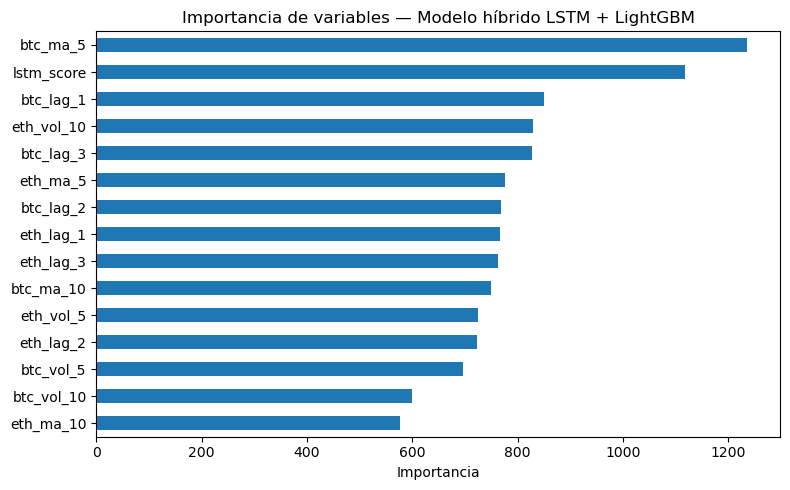

In [25]:
# Este modelo combina la señal secuencial aprendida por el LSTM con las variables tabulares tradicionales del modelo LightGBM. De esta forma, LightGBM puede usar la "memoria" del LSTM como una nueva feature.

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

#Generamos las predicciones del LSTM para todo el conjunto de datos (menos los primeros time_steps)
# Usamos el generador de secuencias ya escalado (X_scaled, y)
lstm_pred = model.predict(generator)  # Predicciones de probabilidad (0–1)

# Alineamos con el dataset original (perdemos los primeros 'time_steps')
data_hybrid = data.iloc[time_steps:].copy()
data_hybrid["lstm_score"] = lstm_pred

#Definimos las features híbridas
# Usamos las mismas features que el modelo base + la predicción LSTM
features_hybrid = [
    "btc_lag_1", "btc_lag_2", "btc_lag_3",
    "btc_ma_5", "btc_ma_10", "btc_vol_5", "btc_vol_10",
    "eth_lag_1", "eth_lag_2", "eth_lag_3",
    "eth_ma_5", "eth_ma_10", "eth_vol_5", "eth_vol_10",
    "lstm_score"
]

X = data_hybrid[features_hybrid]
y = data_hybrid["target"]

#División temporal (sin mezclar fechas)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

#Entrenamiento del modelo híbrido con LightGBM
model_hybrid = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_hybrid.fit(X_train, y_train)

#Evaluación del modelo híbrido
y_proba = model_hybrid.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print(f"AUC del modelo híbrido (LSTM + LightGBM): {auc:.3f}")

#Importancia de variables
importances = pd.Series(model_hybrid.feature_importances_, index=features_hybrid)
importances.sort_values(ascending=True).plot(kind="barh", figsize=(8,5))
plt.title("Importancia de variables — Modelo híbrido LSTM + LightGBM")
plt.xlabel("Importancia")
plt.tight_layout()
plt.savefig("figures/importance_hybrid_model.png", dpi=300, bbox_inches="tight")
plt.show()


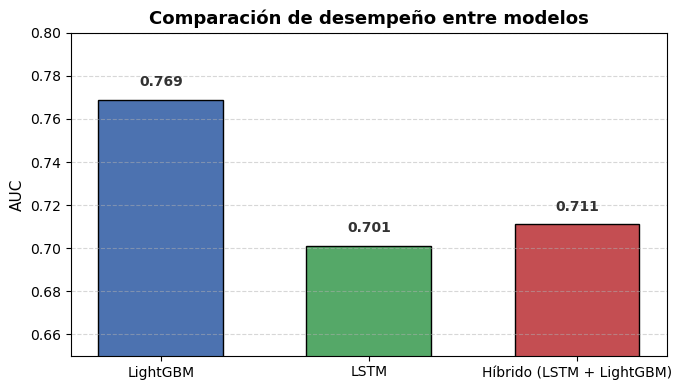

In [26]:
#Comparación visual de desempeño entre modelos

import os
import matplotlib.pyplot as plt

# AUC de los tres modelos
modelos = ["LightGBM", "LSTM", "Híbrido (LSTM + LightGBM)"]
auc_scores = [0.769, 0.701, 0.711]

# Configuración del gráfico
plt.figure(figsize=(7, 4))
bars = plt.bar(modelos, auc_scores, color=["#4c72b0", "#55a868", "#c44e52"], width=0.6, edgecolor='black')

# Títulos y ejes
plt.title("Comparación de desempeño entre modelos", fontsize=13, weight='bold')
plt.ylabel("AUC", fontsize=11)
plt.ylim(0.65, 0.80)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar el valor numérico sobre cada barra
for bar, auc in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, auc + 0.005, f"{auc:.3f}",
             ha="center", va="bottom", fontsize=10, fontweight="bold", color="#333333")

# Guardar figura
plt.tight_layout()
plt.savefig("figures/comparacion_auc_modelos.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# 10) Evaluación visual de que el modelo funciona

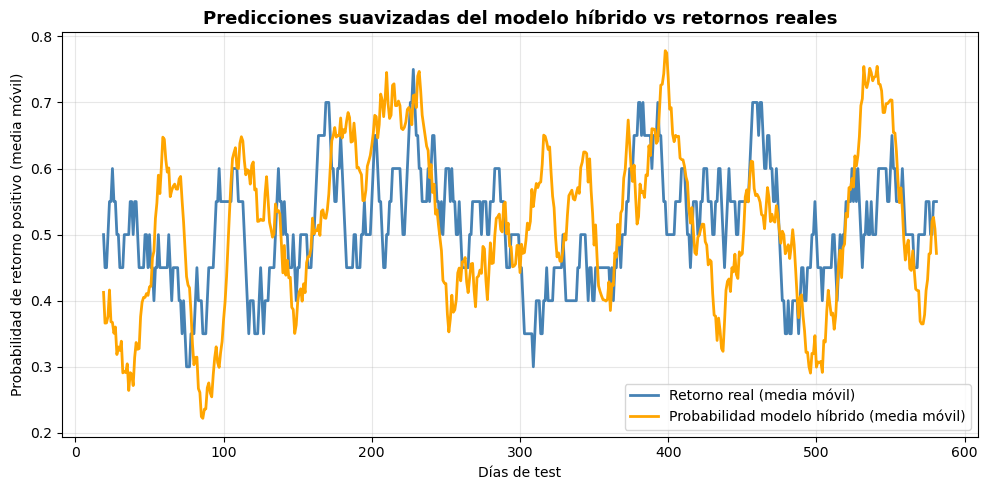

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir a series para suavizar
pred = pd.Series(y_proba)
real = pd.Series(y_test.reset_index(drop=True).values)

# Suavizamos con una media móvil de 20 días
pred_smooth = pred.rolling(20).mean()
real_smooth = real.rolling(20).mean()

plt.figure(figsize=(10,5))
plt.plot(real_smooth, label="Retorno real (media móvil)", color="steelblue", linewidth=2)
plt.plot(pred_smooth, label="Probabilidad modelo híbrido (media móvil)", color="orange", linewidth=2)
plt.title("Predicciones suavizadas del modelo híbrido vs retornos reales", fontsize=13, weight='bold')
plt.xlabel("Días de test")
plt.ylabel("Probabilidad de retorno positivo (media móvil)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
